> *It is recommended to work with this tutorial in the [Chrome](https://www.google.com/intl/en_uk/chrome/) browser.*

> *To run any cell in the Jupyter notebook (this file), make sure you are in the cell you want to run and press Shift + Enter or ▶ **Run** at the top. To run all of the cells, press ▶▶ (fast forward) button at the top. In case the notebook stops respoding, you can press ⟳ (restart the kernel) button at the top.*

> *To be able to complete this tutorial, an external mesh generation software is required. [Gmsh](https://gmsh.info) is an open source program, which can be installed on Windows, macOS or Linux. The steps for creating a mesh using Gmsh are discussed later in this tutorial.*

# Unsaturated flow in 2D

This tutorial deals with the usage of the **unsaturated_2Dflow** module of [MoFEM](http://mofem.eng.gla.ac.uk/) to simulate/analyse the flow of water or chemicals (or fluid in general) in a variably saturated matrix. The emphasis in this tutorial is not on the finite element implementation; it is rather on the mesh preprocessing and description of how to run the code. 

<img src="http://mofem.eng.gla.ac.uk/mofem/html/flow_rec.gif" width="600">

The presentation includes:
- An overview of the mathematical equation
- Creation of the geometry and physical groups in Gmsh
- Meshing the geometry in Gmsh 
- Executing the code and choosing input parameters 
- Converting output to images
- Visualizing animated output

## Unsaturated flow model

The mathematical equation describing the movement of water or chemicals in a variably 
saturated matrix is usually given by Richards' equation, see [[Vogel, 2000]](#vogel_2000):

\begin{equation}
\frac{\partial \theta(h)}{\partial t} - \mathrm{div}\,[K(h)\,\mathrm{grad}\,(h - z)] = 0,
\end{equation}

where $h$ is the unknown pressure head, $\theta$ is the water (chemical) content as a function of $h$, $K$ is the hydraulic conductivity. The variable $z$ refers to the 
vertical distance in the case of vertical flow against the action of gravitational 
force. However, when the flow is assumed to be restricted in the horizontal plane 
(i.e., $z$ is constant), the contribution of gravity is ignored.   

A full description of the above model requires constitutive laws for the fluid content 
$\theta(h)$ and the hydraulic conductivity $K(h)$, as well as the boundary and initial conditions. These 
constitutive laws depend on the particular material properties under consideration (both for the matrix and for the fluid).

In this example, we consider the modified van Genuchten model, see [[Vogel, 2000]](#vogel_2000). The constitutive equation for the volumetric fluid content is given as
\begin{equation} 
\theta(h) = \begin{cases} 
      \theta_r + \frac{\theta_s - \theta_r}{[1+(-\alpha h)^n]m}, & h < h_s\\
      \theta_s, & h\geq h_s,
   \end{cases}
\end{equation}
where $\theta_r$ and $\theta_s$ are positive material parameters referred to as residual 
and saturated fluid contents, respectively. The parameter $h_s$ is the minimal capillary pressure, 
and $\theta_m$ is a fictitious modelling parameter, while $\alpha$ and $n$ are empirical 
shape parameters. In addition, the constitutive equation for the hydraulic conductivity is given by

\begin{equation} 
K(h) = \begin{cases} 
      K_s\,K_r(h), & h < h_s\\
      K_s, & h\geq h_s,
   \end{cases}
\end{equation}
where $K_s$ is the saturated hydraulic conductivity and $K_r$ is the unsaturated hydraulic 
conductivity, which is related to $h$ through the effective saturation $S_e$ (volume fraction representing 
the composition of fluid in the matrix-fluid mixture) by
\begin{equation}
K_r = S_e^\ell \bigg[ \frac{1-F(S_e)}{1-F(1)}\bigg]^2,
\end{equation}

where $\ell$ is the pore connectivity parameter usually assumed to be $0.5$, and the 
function $F$ is given by

\begin{equation}
F = \bigg[1-\bigg(\frac{\theta_s - \theta_r}{\theta_m - \theta_r}S_e\bigg)^{1/m}\bigg]^m
\end{equation}
and the effective saturation is given by
\begin{equation}
S_e = \frac{\theta - \theta_r}{\theta_s - \theta_r}.
\end{equation}
Here $m = 1 - 1/n$, $n>1$.

The values of the parameters used in this tutorial have been chosen as follows: $K_s = 0.01 \,\text{mm/s}, \ell = 0.5, \theta_r = 0.0, \theta_s = 0.17, \theta_m = 0.17, n = 2.8, \alpha = 0.06 \,\text{mm}^{-1}$ and $h_s = 0.0$, see [[Aslannejad, 2017]](#aslannejad_2017).

The boundary conditions are divided into two parts (see Figure 1); one that prescribes the pressure 
head $h$ on a given part of the boundary $\Gamma_1$, the other one prescribes the flux on 
the rest of the boundary $\Gamma_2 = \partial\Omega - \Gamma_1$. Usually the second type of 
boundary condition is zero flux which corresponds to an insulation of the boundary, i.e., no 
fluid is coming in and out of the boundary.

The initial condition prescribes the pressure head $h$ at the beginning of the simulation, 
in this example we consider a homogeneous initial condition, i.e., $h = h_0$



## References

<a id='vogel_2000'></a> 
**[Vogel, 2000]** Vogel, T., Van Genuchten, M.T. and Cislerova, M., 2000. Effect of the shape of the soil hydraulic functions near saturation on variably-saturated flow predictions. Advances in water resources, 24(2), pp.133-144.

<a id='aslannejad_2017'></a> 
**[Aslannejad, 2017]** Aslannejad, H. and Hassanizadeh, S.M., 2017. Study of hydraulic properties of uncoated paper: image analysis and pore-scale modeling. Transport in porous media, 120(1), pp.67-81.

## Creating the geometry

The problem considered in this tutorial is the lateral flow of a dissolvable fluid in a simple 
rectangular paper slide as shown in Figure 1. Part of the boundary labeled $\Gamma_1$ 
is in contact with a source of the fluid associated with pressure head $h = C$. The rest of the boundary, i.e., 
$\Gamma_2$, is insulated. 

<img src="http://mofem.eng.gla.ac.uk/mofem/html/domain.png" title="Figure 1: Domain and boundary decomposition" width="600">
<center>Figure 1: Domain and boundary decomposition</center>

The geometry of the paper slide $\Omega$ has been created in [Gmsh](https://gmsh.info), a open-source mesh generating software. Later, the 
geometry has been saved in to a .geo file that can be opened in any text editor, 
which in turn provides an alternative way of modifying it. 
 
A simple two step procedure to create this rectangular geometry is as follows: first open the Gmsh software, then go to 

`
File -> New -> Choose directory -> give name (e.g., paper_network.geo) -> save -> choose OpenCASCADE from the dialogue box
`

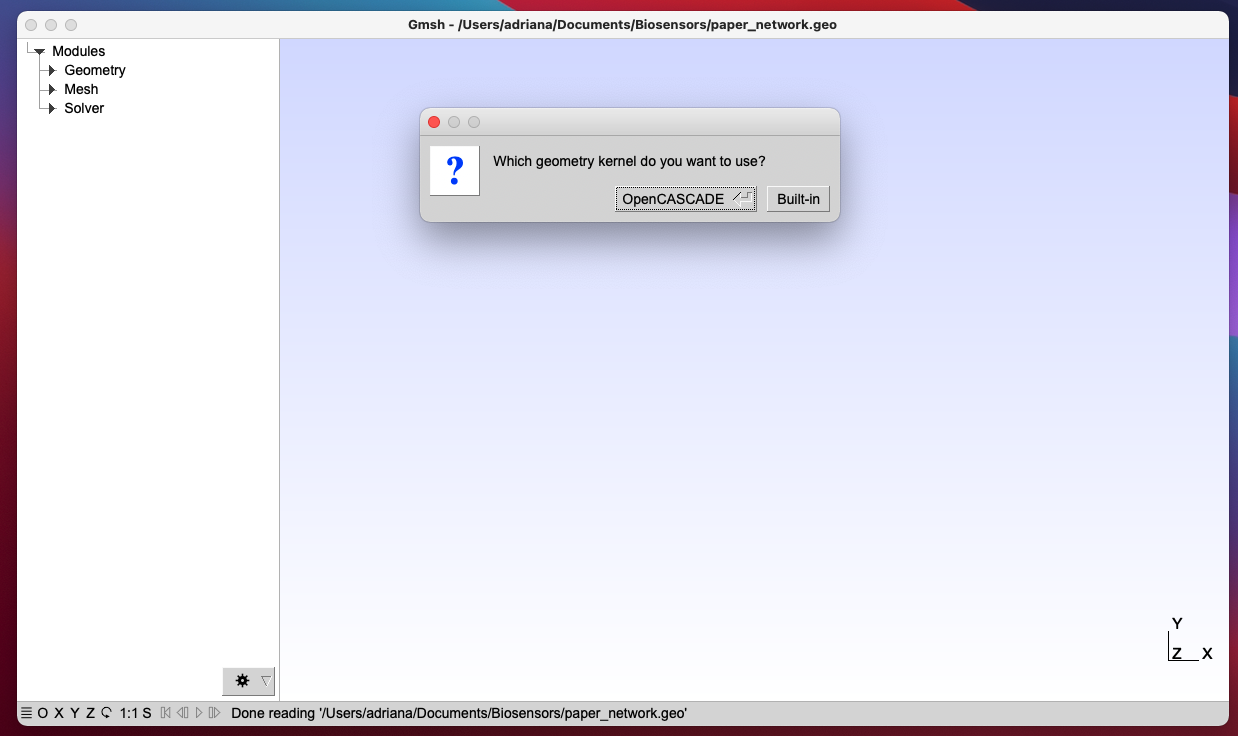

Next, on the left click on the **Module**; this opens three branches namely **Geometry**, **Mesh** and **Solver**, then follow

`
Geometry -> Elementary entities -> Add -> Rectangle  
`

A dialogue page appears as shown below, press "Shift" key to hold position and enter X = 0, Y = 0, Z = 0 as the coordinates of 
the left corner of the rectangle and enter DX = 20 and DY = 5 as the dimensions, make sure that **radius rounded** is set to 0. 
Then click **Add** on the dialogue box. The values used are in milimeters.

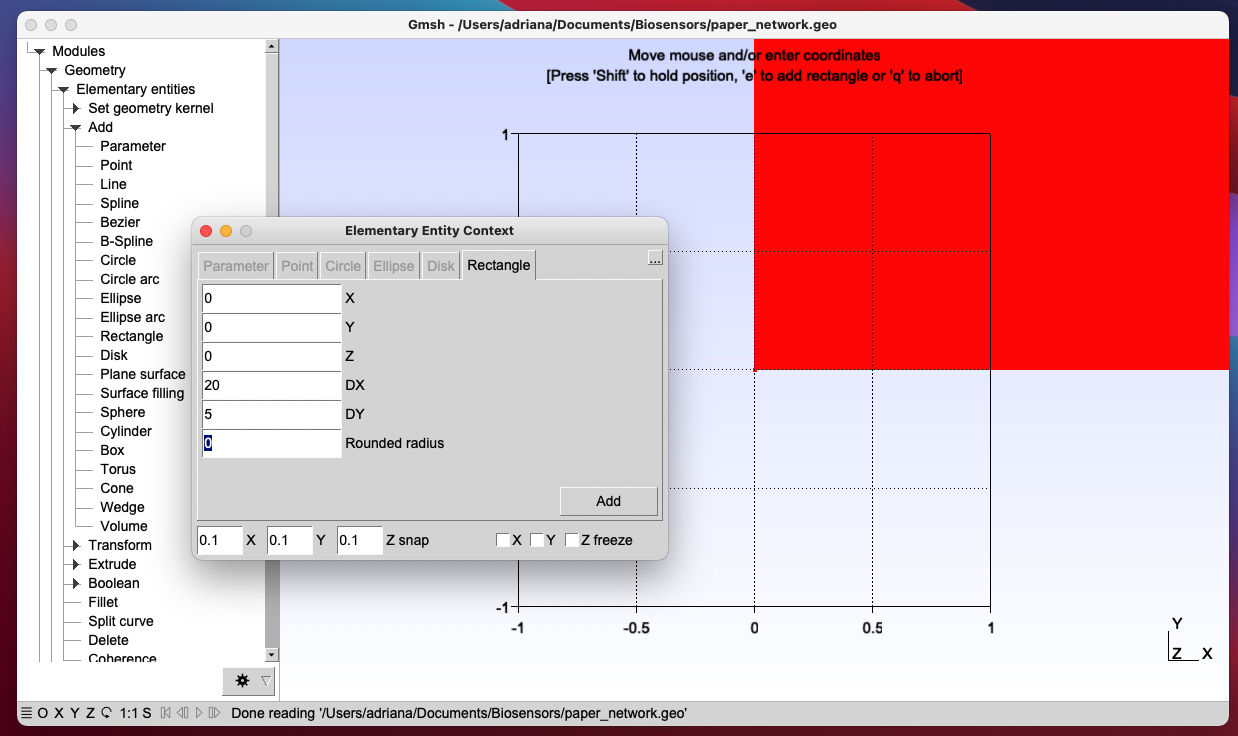

To finish creating the rectangle press "q" key to abort. Now the rectangle is created.

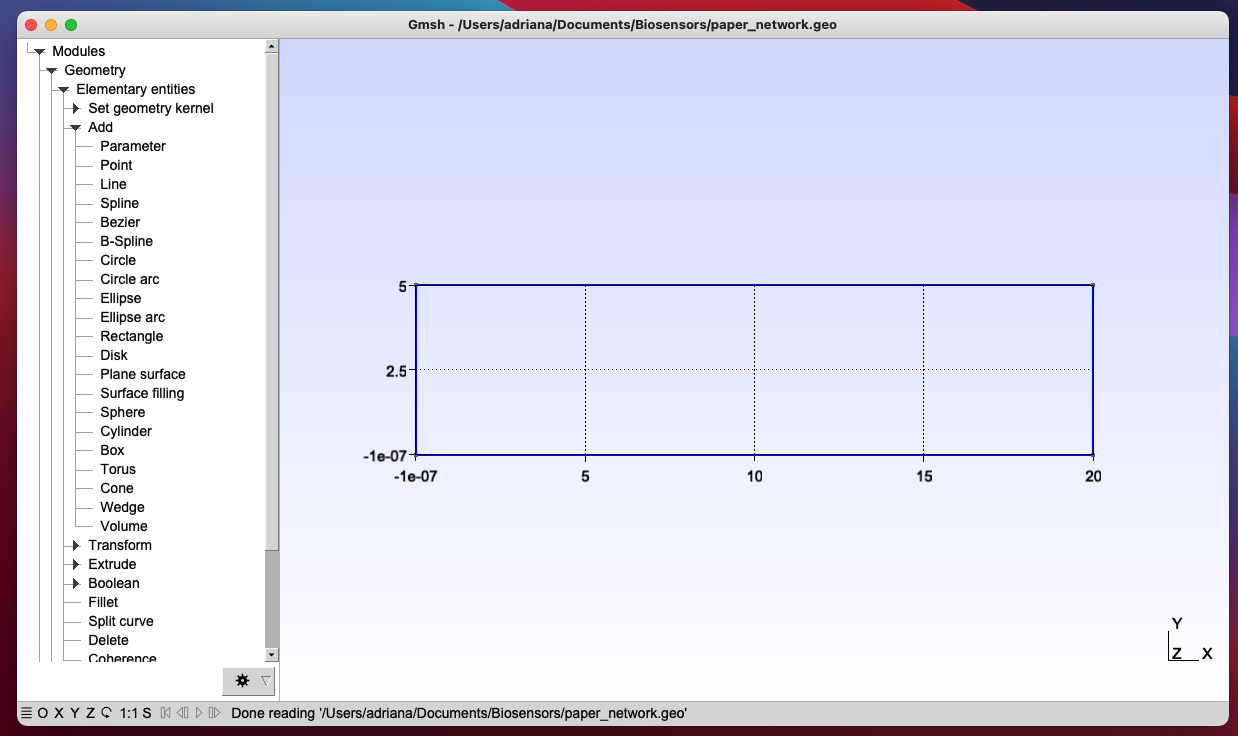

> ***Notes:*** <br> 
> Later on, when you will want to create more complicated geometries you can use Boolean operations:
`
Geometry -> Elementary entities -> Boolean
`.
> For Boolean to work correctly for 2D surfaces, all of them have to have the same orientation. Consistency in the orientation can be achieved by:
> - always creating shapes starting from bottom left and ending top right
> - making sure the node numbering is anticlockwise\
(if you want to see your point numbering tick the **Point labels** box in the next picture)

## Physical groups

Physical groups refer to regions in the domain where various values are prescribed, for example, boundary conditions, 
initial conditions, material parameters etc. For the problem under consideration, we only need two types of physical groups, initial 
and boundary conditions. Now go back to our rectangle in Gmsh. Note that every  **Point**, **Line** or **Plane** is allocated a unique ID by Gmsh 
as it is created, automatically. To view such IDs, under the **Tools** Menu choose **Options**, and in the dialogue box that appears
press on the **Geometry** menu on the left then under **Visibility** check **Curve labels** and **Surface labels** then close the dialogue box.

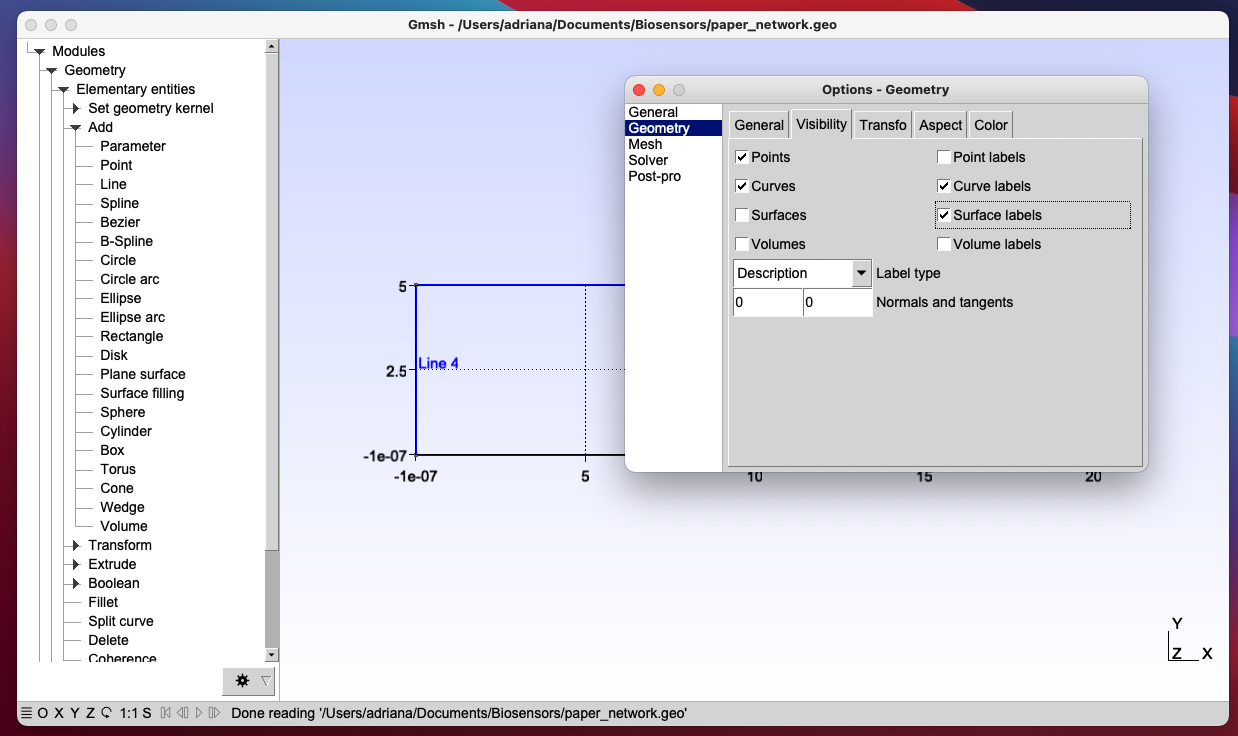

To create the boundary entity where pressure head $h$ is prescribed i.e., $\Gamma_1$ (Note that it is Line 4), follow

`
Module -> Geometry -> Physical groups -> Add -> Curve
`

Give it the name **ESSENTIAL** on the dialogue box appearing. Hover the cursor over the rectangle and click on **Line 4** to select it (its color changes to red), and Press "e" to end selection and "q" to abort. 

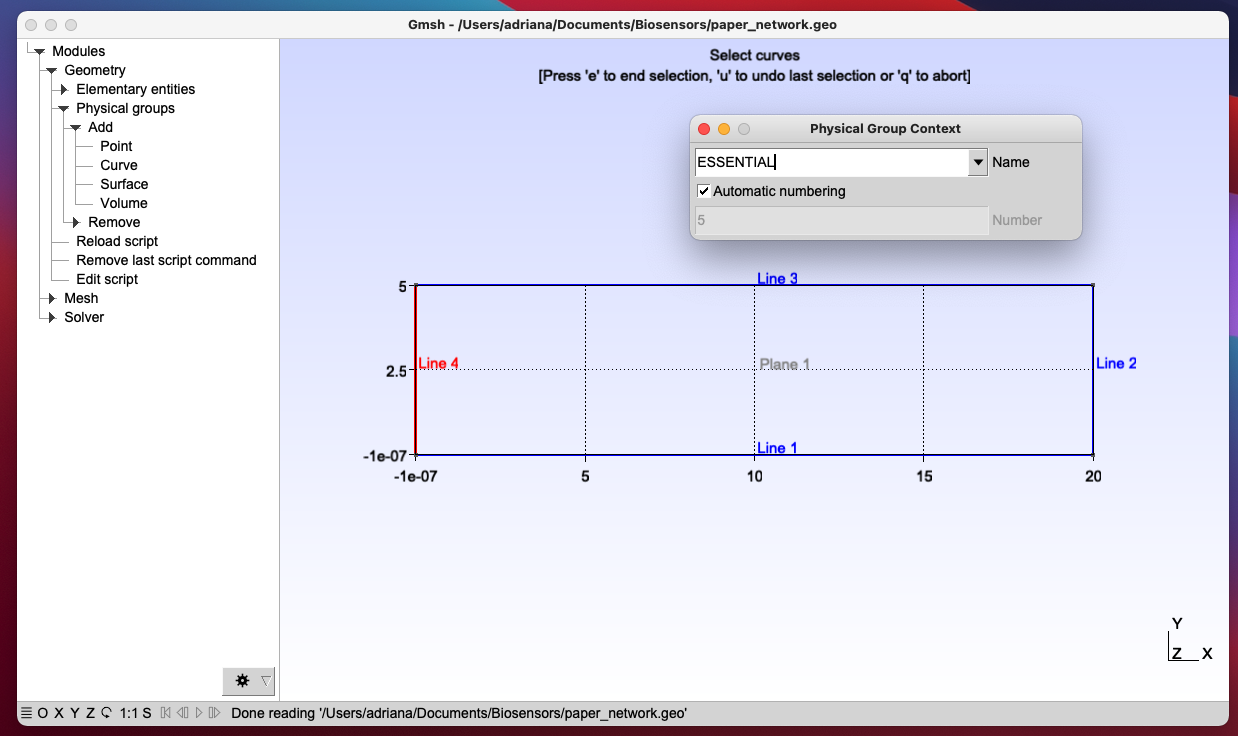

Next to choose the Physical Group where the initial condition is prescribed (in this case, only one initial condition which is prescribed over the entire
rectangle, i.e. Plane 1, is considered), follow  

`
Module -> Geometry -> Physical groups -> Add -> Surface
`

on the dialogue box give it the name **INITIAL** and the hover over the rectangle and 
select **Plane 1**, afterwards press "e" to end selection and "q" to abort. **INITIAL** name ensures that the material properties and the initial state of the material are assigned to the plane chosen and passed to the analysis. If your geomerty gets more complicated, remember to apply the name **INITIAL** to any surface which is to be included in the analysis, but preferably unify them beforehand.

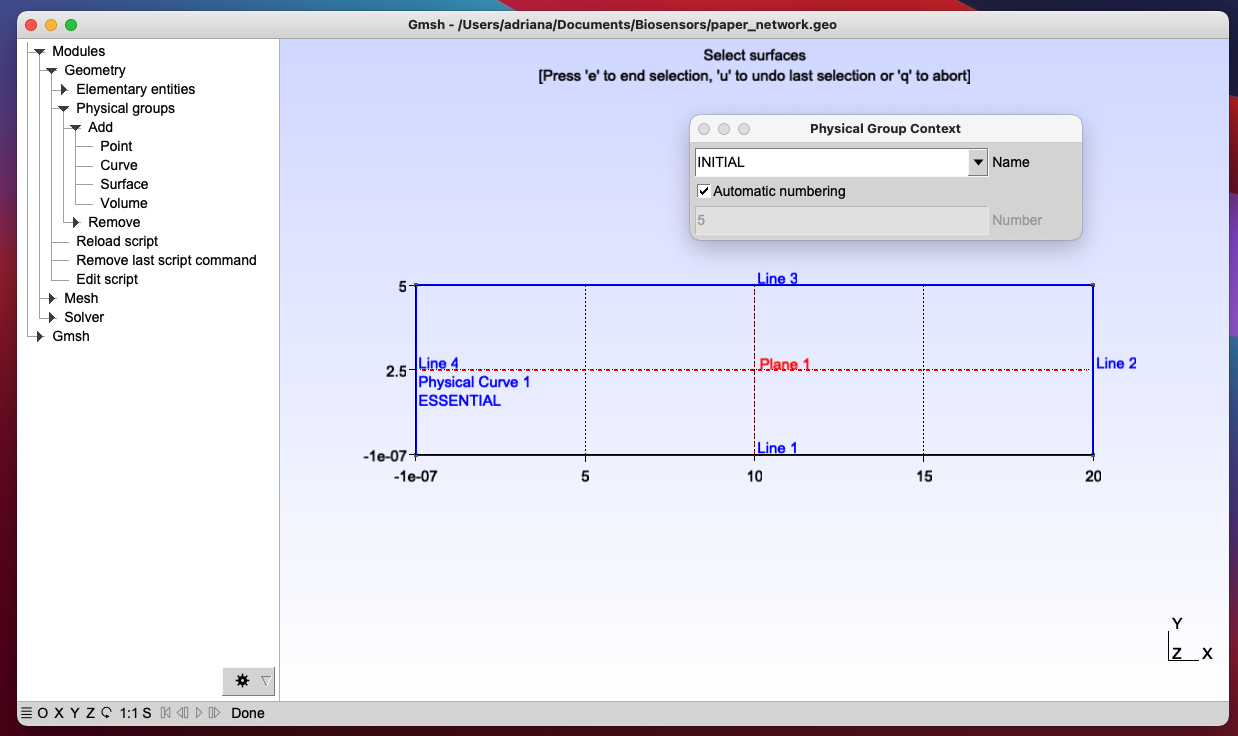

This results in the file [**paper_network.geo**](paper_network.geo)

`
// Gmsh project created on Mon Jan 27 21:51:41 2020
SetFactory("OpenCASCADE");
Rectangle(1) = {0, 0, 0, 20, 5, 0};
Physical Curve("ESSENTIAL", 1) = {4};
Physical Surface("INITIAL", 2) = {1};
`

which you can open with any text editor from which you can modify the geometry, for example, for later use we can create variables `lx` and `ly`
for dimensions of the rectangle as follows

`
// Gmsh project created on Mon Jan 27 21:51:41 2020
SetFactory("OpenCASCADE");
lx = 20;
ly = 5;
Rectangle(1) = {0, 0, 0, lx, ly, 0};
Physical Curve("ESSENTIAL", 1) = {4};
Physical Surface("INITIAL", 2) = {1};
`

## Meshing 
Creating the mesh is simple, once we have the .geo file setup correctly, you can load the modified **paper_network.geo** file 
as follows 

`
File -> Open... -> select the file you want to load (in this case is paper_network.geo)
`

Then to create the mesh,

`
Module -> Mesh -> 2D 
`

The rectangle is the meshed into relatively coarser triangles. If you want to refine it, just press **Refine by splitting** under 
**Mesh**. (You can repeat pressing it 
as many times as required, to get to an acceptable level of refinement.) 

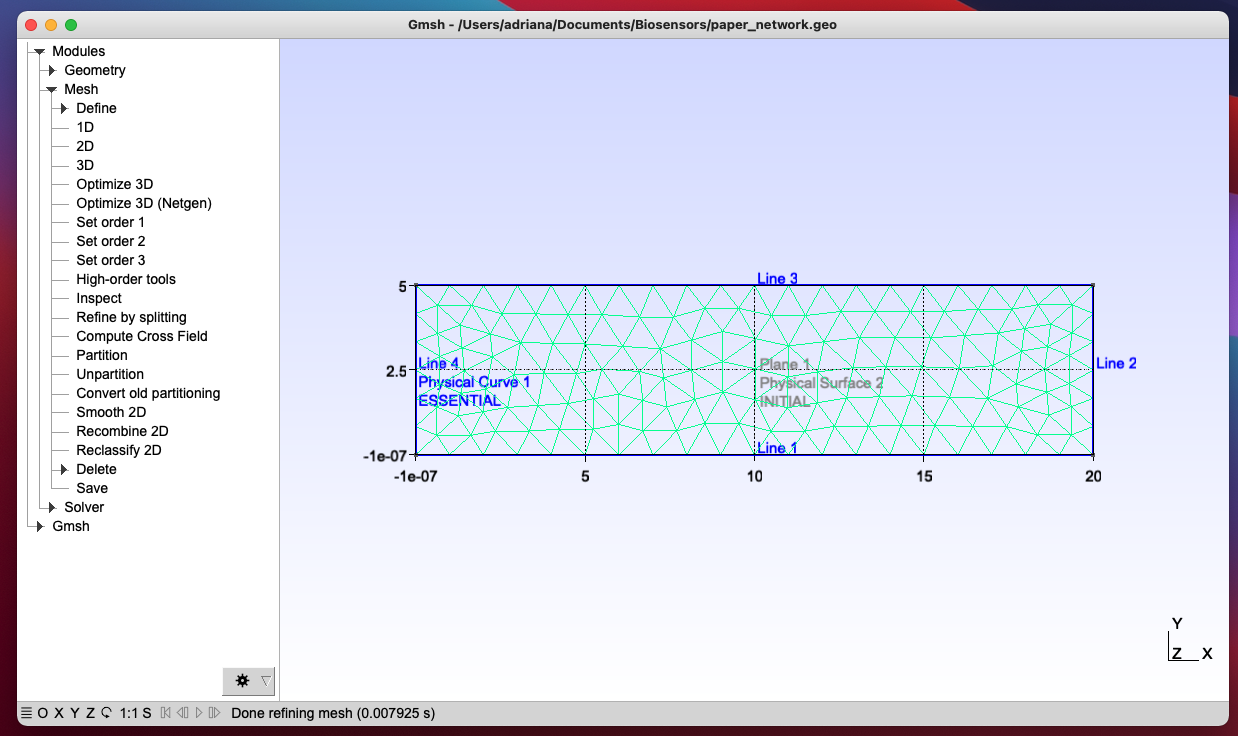

To save the resulting mesh you need to go to 

`
File -> Export -> select a folder you want to save in -> give it a name , e.g., paper_network.med -> save
`

Choose **Select all elements** for the MED Options, and press **OK**.

At this point, we have everything we need to run the program. 

## Upload mesh to Jupyter

To let this setup use the mesh you created, upload it to the Jupyter folder `/unsaturated_2Dflow` or wherever your working directory with **unsaturated_2Dflow** program is.

The **Upload** button is usually located in the top right corner next to **New** and bellow **Quit**. Unfortunately, some browsers do not support this function. If you have this issue, try to use a different browser for uploading the file (Chrome works).




# Running the code

> ***Notes:*** <br>
> - run cell with Shift + Enter or ▶
> - if variable is manually changed, run the cell to update it
> - `In [*]` means the cell is being executed
> - if while running a cell Jupyter doesn't recognise a variable, try running everything with ▶▶ to ensure all information was passed before looking for other errors




## Set directories (no change needed)

In [ ]:
user_name=!whoami
user_name=user_name[0]

print("User name:", user_name)

wd = !pwd
toold = "~/um_view/bin"
unsaturated_flow = "~/um_view/softmech/unsaturated_2Dflow/unsatu2dFlow_prob"
!ls {unsaturated_flow}
# if you get error executing this cell, check the spelling of your MED file

## Set simulation parameters (change needed)

In [ ]:
mesh_file_name = "paper_network.med"  # replace with the mesh file you'd like to work with

saturated_conductivity = 0.01 # set saturated_conductivity of the paper
# 1e-12 m^2 = 0.01 mm/s = 1 Darcy
time_step = 0.1 # set how big time steps the analysis should use
final_time = 120 # time at which analysis will stop
save_step = 20 # How often save file

# number of files
files_count = int(final_time / time_step / save_step)
mesh_file_found = !ls {mesh_file_name}
if mesh_file_found[0] != mesh_file_name:
    raise Exception("Sorry, file {} not found".format(mesh_file_name))

print(str(files_count) + ' files will be saved')
if files_count > 200:
  raise Exception("Sorry, this would create too many files. Please change final_time, time_step or save_step.")

In the cell above, you can set up the main variables, which are used in this analysis. Change the `mesh_file_name` to the MED file you uploaded. 

The saturated conductivity, $K_s$, for paper varies with the type of paper used. If you want to, you can find your own and input it for `saturated_conductivity`. We took one of the values from a graph in [The anisotropic permeability of paper](https://smartech.gatech.edu/bitstream/handle/1853/3341/tps-298.pdf) on page 26. The units you might encounter vary and you can use the following approximate formula for converting: 
$$ 1 \,\text{Darcy} \approx 10^{-12} \,\text{m}^2 \approx 0.01 \text{mm/s} $$
The units of $K_s$ required as input are $\text{mm/s}$. This will assume that your mesh is in $\text{mm}$ and resulting time will be in seconds.

`final_time` and `time_step` control the analysis. Time starts at $t = 0s$, and `time_step` defines the next point of time at which the analysis is performed. The time will keep increasing by `time_step` until it reaches `final_time`. `save_step` decides which files to save. If `save_step` $= 4$, analysis steps number 0, 4, 8, etc., will be saved.

## Check physical groups in the mesh file (no change needed)

In [ ]:
!{toold}/read_med \
-med_file {mesh_file_name} \
-output_file paper_network_pre.h5m

In the cell above, ESSENTIAL and INITIAL blocksets should be present. If that is not the case, check your geometry/mesh in gmsh.

## Run the analysis

In [ ]:
!{toold}/mofem_part \
-my_file paper_network_pre.h5m \
-output_file paper_network_final.h5m \
-my_nparts 1 -dim 2 -adj_dim 1

!rm -vf out_*

!{unsaturated_flow} \
-file_name paper_network_final.h5m \
-saturated_conductivity {saturated_conductivity} \
-ts_dt {time_step} -save_every_nth_step {save_step} -ts_final_time {final_time} 2>&1 | tee log

In [ ]:
!ls out*h5m # check which output files were created during analysis
# converting analysis files to format readable by post processors
!{toold}/convert.py -np 4 out*

The format of output files which can be read by the postprocessing tools is VTK. If you want more flexibility than is provided in this notebook, you can download these and open them in programs like [Paraview](https://www.paraview.org).

## Plot initial solution on the mesh (no change needed)

In [ ]:
# import required python libraries for post processing
import matplotlib.pyplot as plt
import pyvista as pv
from pyvirtualdisplay import Display
import glob
pv.set_plot_theme("document") # needed?

# plot the mesh and result of the first step of the analysis
display = Display(backend="xvfb", visible=True, size=(1200, 800))
display.start()
my_cmap = plt.cm.get_cmap("summer", 24)
mesh = pv.read("out_level_0.vtk") 
mesh.plot(show_edges=True, cpos = "xy", scalars="h1", cmap = my_cmap)

## Plot evolution of the solution in time

In [ ]:
import ipywidgets
from ipywidgets import Play, IntProgress, link, HBox, AppLayout, Dropdown, VBox, FloatRangeSlider, jslink, GridspecLayout
import ipygany
from ipygany import Scene, PolyMesh, TetraMesh, IsoColor, Threshold, IsoSurface, colormaps, ColorBar

# run but ignore - remove GLOBAL_ID field from VTK files
def remove_global_id_scalars(mask):
    files = sorted(glob.glob(mask))
    for file in files:
        lines=[]
        with open(file,'r') as f:
            lines=f.readlines()
        with open(file,'w') as f:
            scalars_num = 0
            point_data_line = 0
            start_line = 0
            found = False
            for number, line in enumerate(lines):
                if "POINT_DATA" in line:
                    point_data_line = number
                    scalars_num = int(line.split()[1])
                if "GLOBAL_ID" in line:
                    if number == point_data_line + 1:
                        start_line = number
                        found = True
                if not found or number not in range(start_line, start_line+scalars_num+2):
                    f.write(line)                 
remove_global_id_scalars("out_level_*.vtk")

# get the mesh & results from vtks
mesh = PolyMesh.from_vtk('out_level_0.vtk')
def load_step(change):
    mesh.reload('out_level_{}.vtk'.format(str(change['new'])), reload_vertices=True)
# define play buttons and progress bar
play = Play(description='Step:', min=0, max=(final_time / time_step), step=save_step, value=0)
play.observe(load_step, names=['value'])
progress = IntProgress(value=0, step=save_step, min=0, max=(final_time / time_step))
link((progress, 'value'), (play, 'value'))
stepper = HBox((play, progress))

# slider contralling & showing which file number if showing
file_slider = ipywidgets.IntSlider(
    value=0,
    min=0,
    max=final_time / time_step,
    step=save_step,
    description='Step number:',
    disabled=False,
    orientation='horizontal',
    readout=True,
)
link((file_slider, 'value'), (progress, 'value'))
# calculated time from file number
time_text = ipywidgets.FloatText(description='Time [s]:', disabled=True)
def value_changed(change):
    time_text.value = change.new * time_step
file_slider.observe(value_changed, 'value')

# set colours
height_min = -40
height_max = 0
iso = IsoColor(mesh, input='h1', min=height_min, max=height_max)
iso.colormap = colormaps.Turbo
colorbar = ColorBar(iso)

# Create a slider that will dynamically change the boundaries of the colormap
colormap_slider_range = FloatRangeSlider(value=[height_min, height_max], min=height_min, max=height_max, 
                                         step=(height_max - height_min) / 100.)
jslink((iso, 'range'), (colormap_slider_range, 'value'))

# Colormap choice widget
colormap = Dropdown(
    options=colormaps,
    description='colormap:'
)

jslink((iso, 'colormap'), (colormap, 'index'))

# show results
grid = GridspecLayout(1, 3)
# grid[0,0] = VBox((file_slider, stepper, time_text))
grid[0,0] = VBox((file_slider, stepper, time_text))
grid[0,2] = VBox((colormap, colormap_slider_range, colorbar))

AppLayout(header=grid,
          center=Scene([iso])
         )

> ***Notes:*** <br>
>The above script should show you results of your analysis. It is interactive and if you accidentally rotate the results, run the last cell again to restart the view. If you have just one output file, there is more needed to be done with the analysis setup: 
> - Is your mesh too coarse? &rarr; at least 2 triangles per edge
> - Does your analysis diverge? &rarr; start with decreasing time step and/or refining mesh, get the feel for what works and adjust afterwards
> - Is the analysis runnung too slowly? &rarr; decrease time step and/or final time and/or use coarser mesh
> - Is your paper getting wet too fast? &rarr; decrease the time step and final time
> - Is your result barely moving even when reaching the final time? &rarr; increase final time and time step

## Exercises

### 1. At which point is the paper wet enough?

In this example, the results are given in $h \,[\text{mm}]$ which correspond to the fluid pressure head. The range of colours indicate how wet the paper is. To start a chemical/enzyme reaction, the paper does not need to be completely soaked $(h = 0)$. What ensures the reaction is the saturation $S_e$ or fluid content $\theta$ of the paper, both of which can be calculated from the pressure head $h$ by the theory given at the top of this notebook. For easier reference, you can also use the plots bellow.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = "Sans"
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 150

h = np.linspace(-40, 0, 1000)
l = 0.5
theta_r = 0.0
theta_s = 0.17
theta_m = 0.17
n = 2.8
m = 1. - 1./n
alpha = 0.06
theta = theta_r + (theta_s - theta_r)/pow(1.0 + pow(-alpha*h, n), m)

S_e = (theta - theta_r)/(theta_s - theta_r)

f, (ax1, ax2) = plt.subplots(1, 2)
f.tight_layout(pad=5)

ax1.plot(h, S_e)
ax1.set_ylim(0, 1)
ax1.set_xlim(-40, 0)
ax1.set_xlabel('Pressure head, h [mm]')
ax1.set_ylabel(r'Effective saturation, $S_e$')
ax1.grid()

ax2.plot(h, theta)
ax2.set_ylim(0, 0.18)
ax2.set_xlim(-40, 0)
ax2.set_xlabel('Pressure head, h [mm]')
ax2.set_ylabel(r'Volumetric fluid content, $\theta$')
ax2.grid()

### 2. Add more features to the geometry. 

For example, a geometry consisting of two rectangles separated by an angle $\pi/3$, as shown

<img src="http://mofem.eng.gla.ac.uk/mofem/html/two_rec.png" width="800">

and the geo file **two_rec.geo** is 

`
// Gmsh project created on Mon Jan 27 21:51:41 2020
lx = 0.02;    
ly = 0.005;
SetFactory("OpenCASCADE");
`

`
Rectangle(1) = {0, 0, 0, lx, ly, 0};
Rotate {{0, 0, 1}, {lx, ly/2, 0}, Pi/3} { Duplicata { Surface{1}; }} 
BooleanUnion { Surface{1}; } { Surface{2}; }
Recursive Delete { Surface{1}; Surface{2}; }
`

`
Physical Curve("ESSENTIAL", 1) = {8};
Physical Surface("INITIAL", 2) = {3};
`
   
   Understand what each line is about. Create the corresponding mesh and execute the code with it. Now create a geometry such as this
   
   <img src="http://mofem.eng.gla.ac.uk/mofem/html/star_geo.png" width="800">
   
   Create a mesh with it and run the code using the mesh. 